# Estimating prediction sets on the Cifar10 dataset

In this tutorial, we use :class:`mapie.regression.MapieClassifier` to compare the prediction sets estimated by several conformal methods on the Cifar10 dataset. To this aim, we define and train a simple convolutional neural network using Tensorflow. We then convert it to the `scikit-learn` API so we can use it with MAPIE to estimate prediction sets with various conformal methods. 

## Tutorial preparation

In [130]:
import sys
import random
import warnings

import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

from mapie.metrics import classification_coverage_score
from mapie.classification import MapieClassifier

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

SPACE_BETWEEN_LABELS = 2.5
SPACE_IN_SUBPLOTS = 4.0
FONT_SIZE = 18

## 1. Data loading

The Cifar10 dataset is downloaded from the `Tensorflow Datasets` library. The training set is then splitted into a training and a calibration set. The training set will be used to fit our neural network, the calibration set will be used by MAPIE to calibrate the conformal methods for estimating the prediction sets.

In [3]:
def load_data(name):
    dataset, info = tfds.load(name, batch_size=-1, as_supervised=True, with_info=True)
    label_names = info.features['label'].names
    dataset = tfds.as_numpy(dataset)
    X_train, y_train = dataset['train']
    X_test, y_test = dataset['test']
    X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
    X_train = 1 - X_train/255.
    X_val = 1 - X_val/255.
    X_calib = 1 - X_calib/255.
    X_test = 1 - X_test/255.
    y_train_oh = tf.keras.utils.to_categorical(y_train)
    y_val_oh = tf.keras.utils.to_categorical(y_val)
    y_calib_oh = tf.keras.utils.to_categorical(y_calib)
    y_test_oh = tf.keras.utils.to_categorical(y_test)
    train_set = (X_train, y_train, y_train_oh)
    val_set = (X_val, y_val, y_val_oh)
    calib_set = (X_calib, y_calib, y_calib_oh)
    test_set = (X_test, y_test, y_test_oh)
    return train_set, val_set, calib_set, test_set, label_names


In [4]:
def inspect_images(X, y, num_images, label_names):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    indices = random.sample(range(len(X)), num_images)
    
    for i, indice in enumerate(indices):
        ax[i].imshow(X[indice])
        ax[i].set_title(label_names[y[indice]])
        ax[i].axis("off")
    plt.show()

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


2021-12-17 16:45:02.599919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vtaquet/miniconda3/envs/mapie_local/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-17 16:45:02.600570: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-17 16:45:02.601320: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in oth

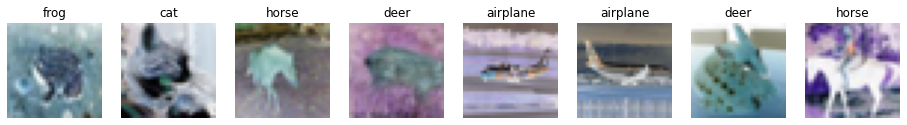

In [5]:
train_set, val_set, calib_set, test_set, label_names = load_data("cifar10")
(X_train, y_train, y_train_oh) = train_set 
(X_val, y_val, y_val_oh) = val_set 
(X_calib, y_calib, y_calib_oh) = calib_set 
(X_test, y_test, y_test_oh) = test_set 
inspect_images(X=X_train, y=y_train, num_images=8, label_names=label_names)

## 2. Definition and training of the the neural network

We define a simple convolutional neural network with the following architecture : 

**Explain the choice of architecture ?**

In [6]:
def get_model(input_shape, loss, optimizer, metrics):
    model = Sequential([
        
        Conv2D(input_shape=input_shape, filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
                
        Conv2D(input_shape=input_shape, filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax'),
    ])
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [7]:
model = get_model(
    input_shape=(32, 32, 3), 
    loss=CategoricalCrossentropy(), 
    optimizer=Adam(), 
    metrics=['accuracy']
)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               2

We then train our neural network on the training set with 20 epochs using early stopping.

In [9]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

model.fit(X_train, y_train_oh, 
          batch_size=64, 
          validation_data=(X_val, y_val_oh), 
          epochs=20, callbacks=[early_stopping_monitor]) 

Epoch 1/20
472/472 [==============================] - 23s 48ms/step - loss: 1.7227 - accuracy: 0.3683 - val_loss: 1.6249 - val_accuracy: 0.4251
Epoch 2/20
472/472 [==============================] - 22s 48ms/step - loss: 1.3690 - accuracy: 0.5068 - val_loss: 1.4130 - val_accuracy: 0.4945
Epoch 3/20
472/472 [==============================] - 22s 47ms/step - loss: 1.2178 - accuracy: 0.5612 - val_loss: 1.2943 - val_accuracy: 0.5411
Epoch 4/20
472/472 [==============================] - 22s 47ms/step - loss: 1.1122 - accuracy: 0.6014 - val_loss: 1.1401 - val_accuracy: 0.5983
Epoch 5/20
472/472 [==============================] - 22s 47ms/step - loss: 1.0169 - accuracy: 0.6395 - val_loss: 1.1233 - val_accuracy: 0.5960
Epoch 6/20
472/472 [==============================] - 22s 47ms/step - loss: 0.9464 - accuracy: 0.6612 - val_loss: 1.0573 - val_accuracy: 0.6285
Epoch 7/20
472/472 [==============================] - 22s 47ms/step - loss: 0.8803 - accuracy: 0.6899 - val_loss: 1.0507 - val_accuracy:

In [10]:
y_true = label_binarize(y=y_test, classes=np.arange(max(y_test)+1))
y_pred_proba = model.predict(X_test)

## 3. Prediction of the prediction sets

In order to use a Tensorflow model in `MapieClassifier`, we first need to convert it to the `scikit-learn` API. It can be done easily with the following class.

In [11]:
class TensorflowToMapie():
    
    def __init__(self, model):
        self.model = model
        self.trained_ = True
        self.classes_ = np.arange(self.model.layers[-1].units)
        
    def fit(self, X, y=None):
        pass
    
    def predict_proba(self, X):
        preds = self.model.predict(X)
        return preds
    
    def predict(self, X):
        pred_proba = self.predict_proba(X)
        pred = (pred_proba == pred_proba.max(axis=1)[:,None]).astype(int)
        return pred
    
    def __sklearn_is_fitted__(self):
        return True


We will now estimate the prediction sets with the five conformal methods implemented in :class:`MapieClassifier` for a range of confidence levels between 0 and 1. 

In [12]:
method_params = {
    "naive": ("naive", False),
    "score": ("score", False),
    "cumulated_score": ("cumulated_score", True),
    "random_cumulated_score": ("cumulated_score", "randomized"),
    "top_k": ("top_k", False)
}
alpha = 0.1

In [13]:
y_preds, y_pss = {}, {}
alphas = np.arange(0.01, 1, 0.01)
for name, (method, include_last_label) in method_params.items():
    mapie_model = TensorflowToMapie(model)
    mapie = MapieClassifier(estimator=mapie_model, method=method, cv="prefit", random_state=42) 
    mapie.fit(X_calib, y_calib, image_input=True)
    y_preds[name], y_pss[name] = mapie.predict(X_test, alpha=alphas, include_last_label=include_last_label)

naive naive False
score score False
cumulated_score cumulated_score True
random_cumulated_score cumulated_score randomized
top_k top_k False


Let's now estimate the number of null prediction sets, marginal coverages, and averaged prediction set sizes obtained with the different methods for all confidence levels and for a confidence level of 90 \%.

In [14]:
def count_null_set(y):
    count = 0
    for pred in y[:, :]:
        if np.sum(pred) == 0:
            count += 1
    return count

In [110]:
nulls, coverages, accuracies, sizes = {}, {}, {}, {}
for name, (method, include_last_label) in method_params.items():
    accuracies[name] = accuracy_score(y_true, y_preds[name])
    nulls[name] = [
        count_null_set(y_pss[name][:, :, i])  for i, _ in enumerate(alphas)
    ]
    coverages[name] = [
        classification_coverage_score(
            y_test, y_pss[name][:, :, i]
        ) for i, _ in enumerate(alphas)
    ]
    sizes[name] = [
        y_pss[name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(alphas)
    ]

In [67]:
coverage_90 = {method: coverage[9] for method, coverage in coverages.items()}
null_90 = {method: null[9] for method, null in nulls.items()}
width_90 = {method: width[9] for method, width in widths.items()}
y_ps_90 = {method: y_ps[:, :, 9] for method, y_ps in y_pss.items()}

Let's now look at the marginal coverages, number of null prediction sets, and the averaged size of prediction sets for a confidence level of 90 \%. 

In [69]:
summary_df = pd.concat(
    [
        pd.Series(coverage_90),
        pd.Series(null_90),
        pd.Series(width_90)
    ],
    axis=1,
    keys=["Coverages", "Number of null sets", "Average prediction set sizes"]
).round(3)

In [70]:
summary_df

,Coverages,Number of null sets,Average prediction set sizes
naive,0.810,0,1.963
score,0.898,0,2.404
cumulated_score,0.931,0,3.014
random_cumulated_score,0.892,97,2.673
top_k,0.899,0,3.000


As expected, the "naive" method, which directly uses the alpha value as a threshold for selecting the prediction sets, does not give guarantees on the marginal coverage since this method is not calibrated. Other methods give a marginal coverage close to the desired one, i.e. 90\%. Notice that the "cumulated_score" method, which always includes the last label whose cumulated score is above the given quantile, tends to give slightly higher marginal coverages since the prediction sets are slightly too big.

## 4. Visualization of the prediction sets

Thanks to this really awesome function, you can generate an amazing summary of prediction sets obtained on a selection of images. Wow !

In [52]:
def prepare_plot(y_methods, n_images):
    plt.rcParams.update({'font.size': FONT_SIZE})
    nrow = len(y_methods.keys())
    ncol = n_images
    s = 5
    f, ax = plt.subplots(ncol, nrow, figsize=(s*nrow, s*ncol))
    f.tight_layout(pad=SPACE_IN_SUBPLOTS)
    rows = [i for i in y_methods.keys()]
    
    for x, row in zip(ax[:,0], rows):
        x.set_ylabel(row, rotation=90, size='large')

    return f, ax

In [53]:
def get_position(y_set, label, count, count_true):
    if y_set[label] :
        position = - (count_true - count)*SPACE_BETWEEN_LABELS
    
    else:
        position = - (count_true + 2 - count)*SPACE_BETWEEN_LABELS
    
    return position

In [54]:
def plot_prediction_sets(X, y, y_pred_proba, y_methods, n_images, label_names, random_state=None):
    random.seed(random_state)
    indices = random.sample(range(len(X)), n_images)
    y_true = y[indices]
    y_pred_proba = y_pred_proba[indices]
    f, ax = prepare_plot(y_methods, n_images)
    for i, method in enumerate(y_methods):
        y_sets = y_methods[method][indices]
        set_max_size = np.max(np.sum(y_sets, axis=1))
        for j in range(n_images) :    
            y_set = y_sets[j]
            img = X[indices[j]]
            label = y_true[j]
            ax[i, j].imshow(img)
            count_true = np.sum(y_set)
            index_sorted_proba = np.argsort(-y_pred_proba[j])
            for count in range(count_true):
                index_pred = index_sorted_proba[count]
                proba = y_pred_proba[j][index_pred]
                label_name = label_names[index_pred]
                color = 'green' if index_pred == y_true[j] else 'red'
                position = get_position(y_set, label, count, count_true)
                ax[i, j].text(
                    15,
                    position,
                    f"{label_name} : {proba:.4f}", 
                    ha="center", va="top", 
                    color=color,
                    font="courier new"
                )
            if not y_set[label] :
                ax[i, j].text(
                    15,
                    -2, 
                    f"True label : {label_names[label]} ({y_pred_proba[j][label]:.4f})", 
                    ha="center",
                    va="bottom", 
                    color='orange',
                    font='courier new'
                )    


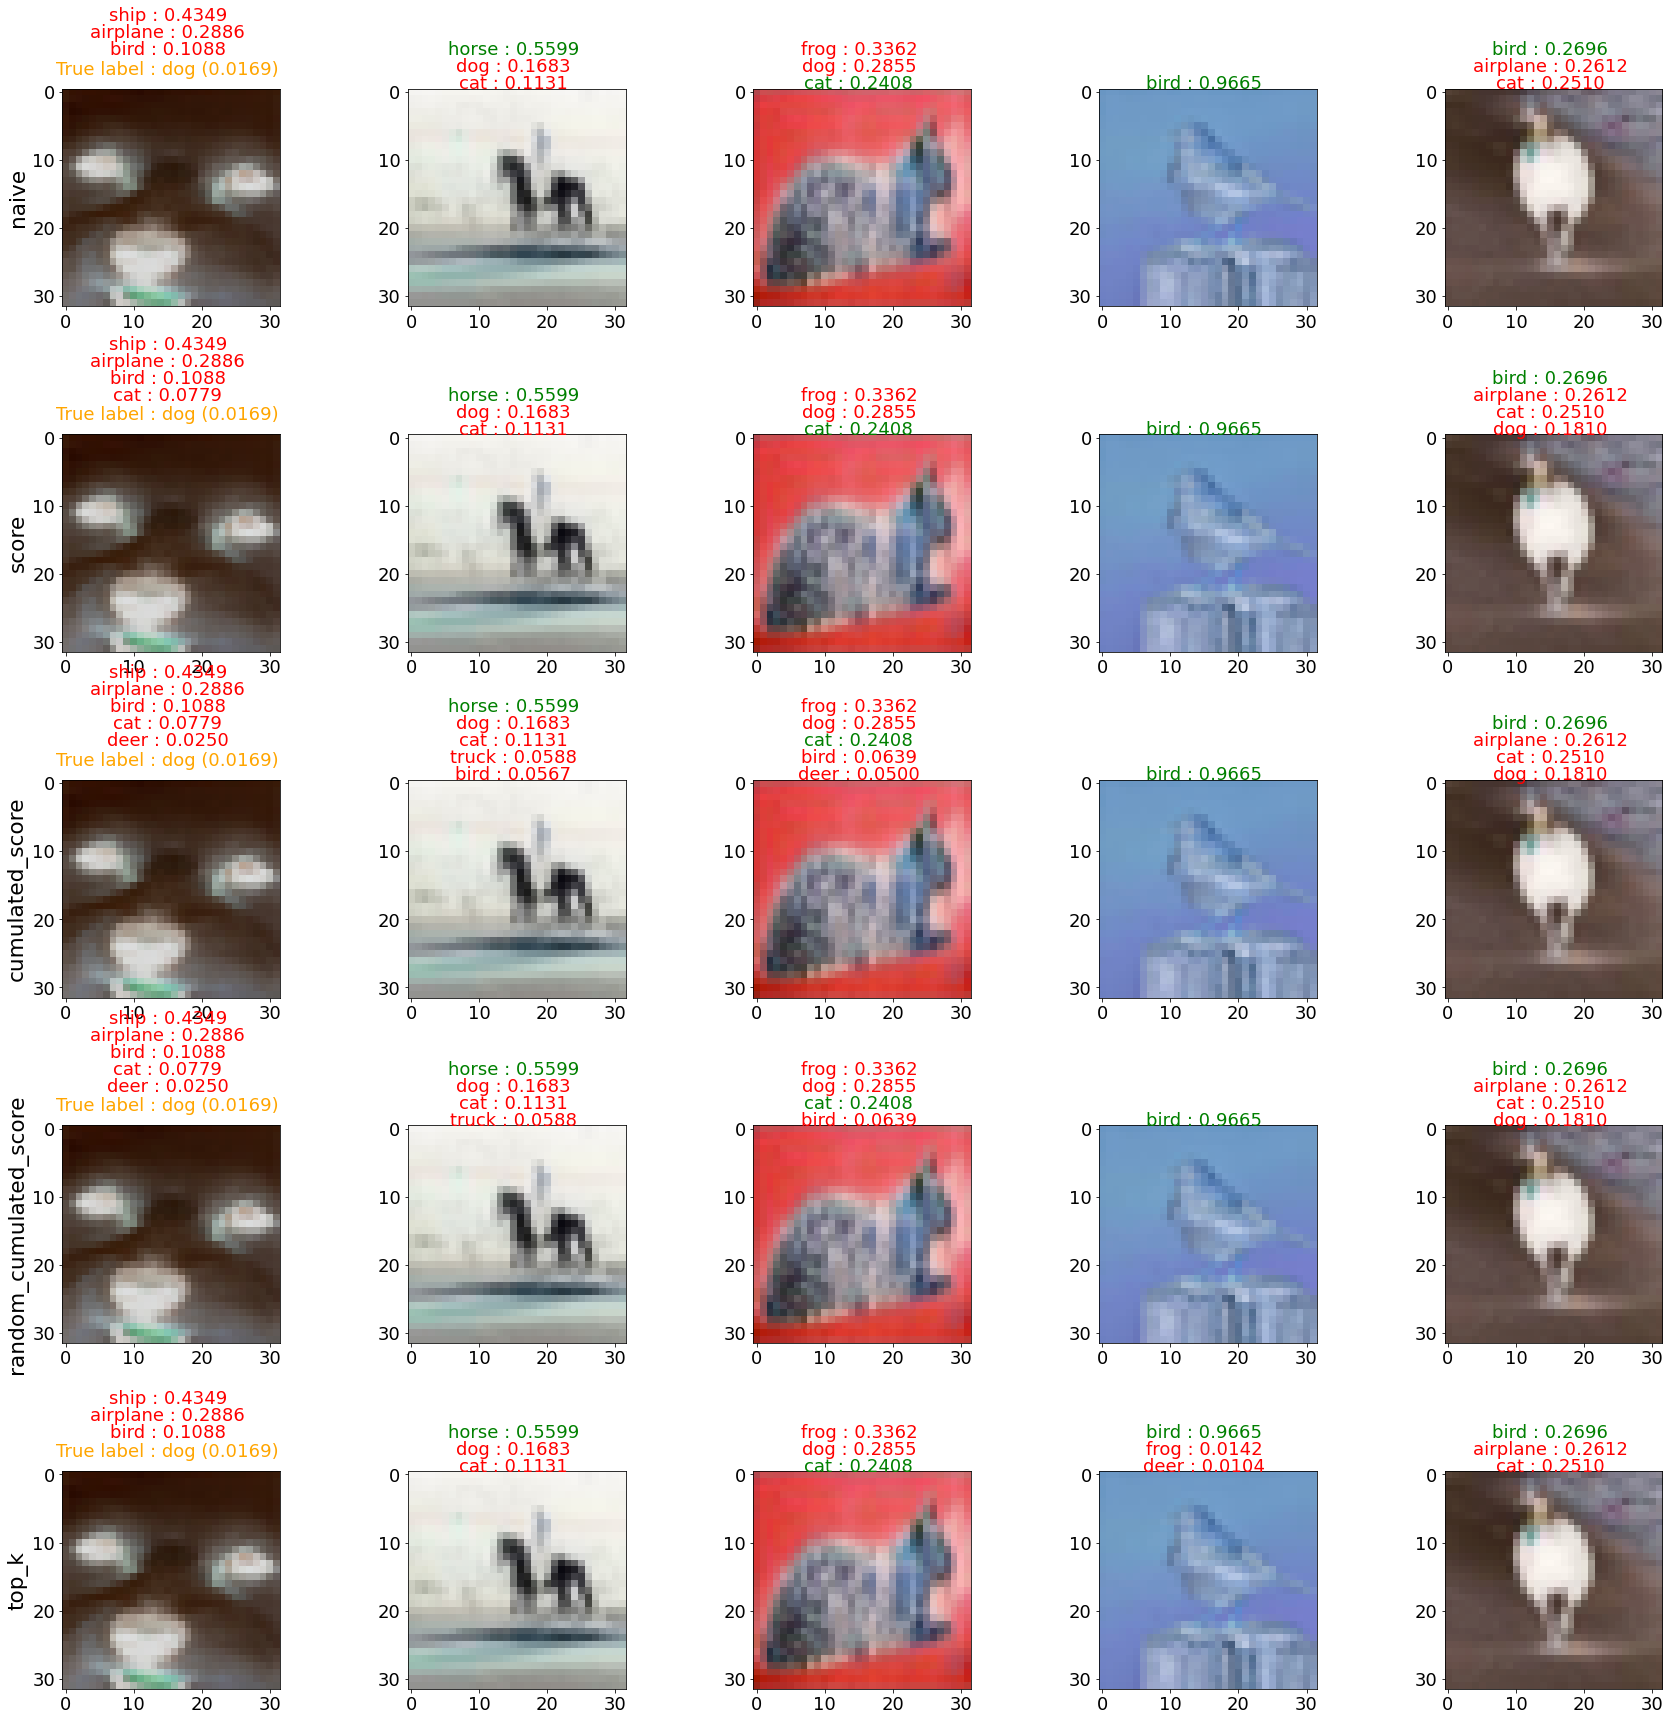

In [71]:
plot_prediction_sets(X_test, y_test, y_pred_proba, y_ps_90, 5, label_names)

## 5. Calibration of the methods

In this section, we plot the number of null sets, the marginal coverages, and the prediction set sizes as function of the target coverage level for all conformal methods. 

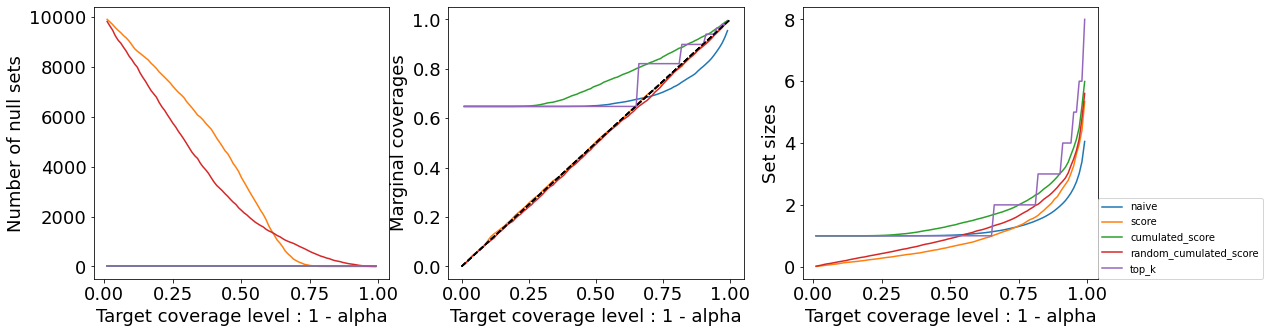

In [129]:
vars_y = [nulls, coverages, sizes]
labels_y = ["Number of null sets", "Marginal coverages", "Set sizes"]
fig, axs = plt.subplots(1, len(vars_y), figsize=(6*len(vars_y), s))
for i, var in enumerate(vars_y):
    for name, (method, include_last_label) in method_params.items():
        axs[i].plot(1 - alphas, var[name], label=name)
        if i == 1:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Target coverage level : 1 - alpha")
    axs[i].set_ylabel(labels_y[i])
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=10, loc=[1, 0])

The two only methods which are perfectly calibrated for the entire range of alpha values are the "score" and "random_cumulated_score". However, these accurate marginal coverages can only be obtained thanks to the generation of null prediction sets. The compromise between estimating null prediction sets with calibrated coverages or non-empty prediction sets but with larger marginal coverages is entirely up to the user.

## 6. Prediction set sizes

In [33]:
def get_histogram(y_methods):
    for method in y_methods:
        ps = y_methods[method]
        sizes = [sum(s)[0] for s in ps]
        plt.hist(sizes)
        plt.title(method)
        plt.show()
        
        

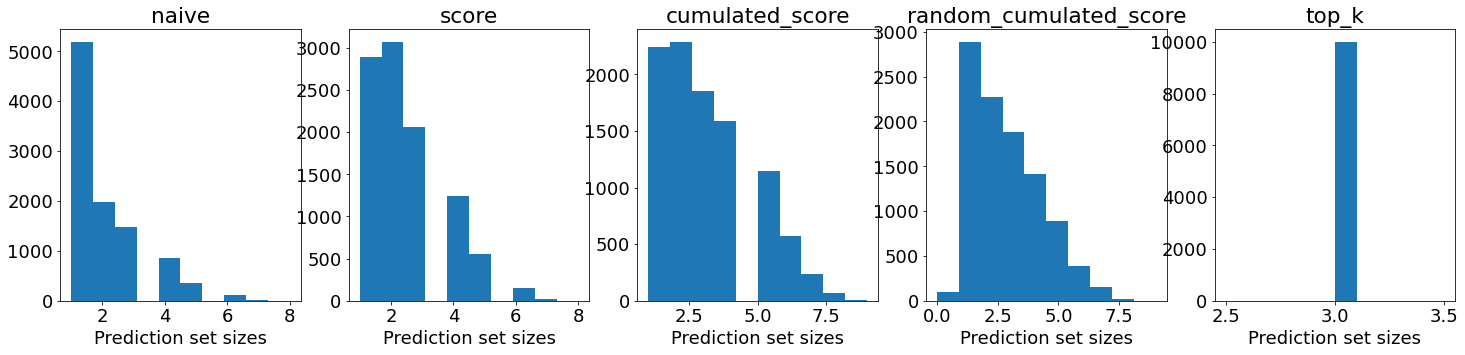

In [64]:
s=5
fig, axs = plt.subplots(1, len(y_preds), figsize=(s*len(y_preds), s))
for i, (method, y_ps) in enumerate(y_ps.items()):
    sizes = y_ps.sum(axis=1)
    axs[i].hist(sizes)
    axs[i].set_xlabel("Prediction set sizes")
    axs[i].set_title(method)

## 7. Conditional coverages

We just saw that all our methods (except the "naive" one) give marginal coverages always larger than the target coverages for alpha values ranging between 0 and 1. However, there is no mathematical guarantees on the *conditional* coverages, i.e. the coverage obtained for a specific class of images. Let's see what conditional coverages we obtain with the different conformal methods.

In [75]:
def get_class_coverage(y_test, y_method, label_names):
    recap ={}
    for method in y_method:
        recap[method] = []
        for label in sorted(np.unique(y_test)):
            indices = np.where(y_test==label)
            label_name = label_names[label]
            y_test_trunc = y_test[indices]
            y_set_trunc = y_method[method][indices]
            score_coverage = classification_coverage_score(y_test_trunc, y_set_trunc)
            recap[method].append(score_coverage)
    recap_df = pd.DataFrame(recap, index = label_names)
    return recap_df
            

In [76]:
class_coverage = get_class_coverage(y_test, y_ps_90, label_names)

<Figure size 432x288 with 0 Axes>

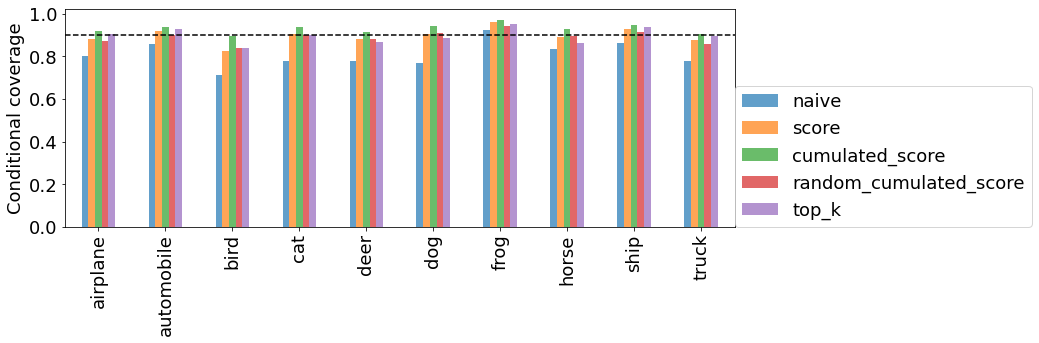

In [101]:
fig = plt.figure()
class_coverage.plot.bar(figsize=(12, 4), alpha=0.7)
plt.axhline(0.9, ls="--", color="k")
plt.ylabel("Conditional coverage")
plt.legend(loc=[1, 0])

We can notice that the conditional coverages slightly vary between classes. The only method whose conditional coverages remain valid for all classes is the "cumulated_score" one.

In [105]:
def create_confusion_matrix(y_ps, y_true):
    number_of_classes = len(np.unique(y_true))
    confusion_matrix = np.zeros((number_of_classes, number_of_classes))
    for i, ps in enumerate(y_ps):
        confusion_matrix[y_true[i]] += ps
    
    return confusion_matrix
    

In [106]:
y_aps = y_ps_90["cumulated_score"]
cm = create_confusion_matrix(y_aps, y_test)

In [107]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

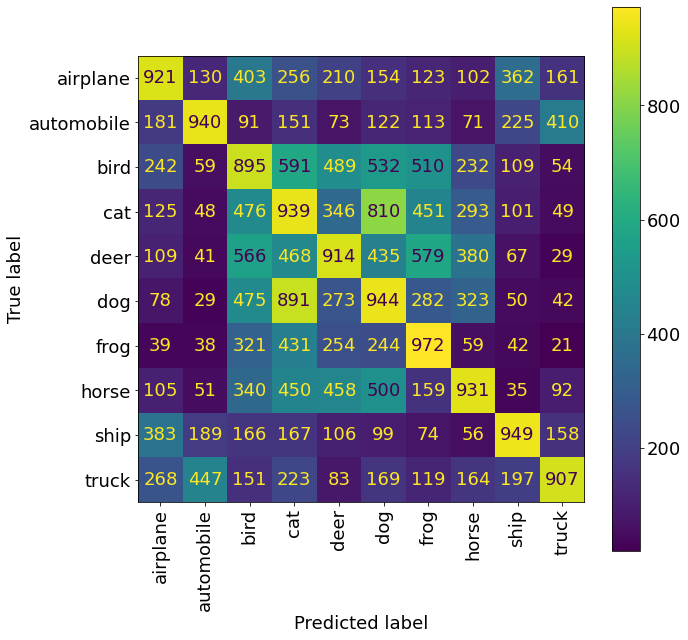

In [108]:
_, ax = plt.subplots(figsize=(10, 10))
disp.plot(
    include_values=True,
    cmap="viridis",
    ax=ax,
    xticks_rotation="vertical",
    values_format='.0f',
    colorbar=True,
)
